# Deep Learning - Reconhecimento de Imagens
- Pedro Henrique Araújo
- Lucas Barros Fernandes
- Fabio Ramacciotti Krakauer
- Lucas Borges

## Atividade

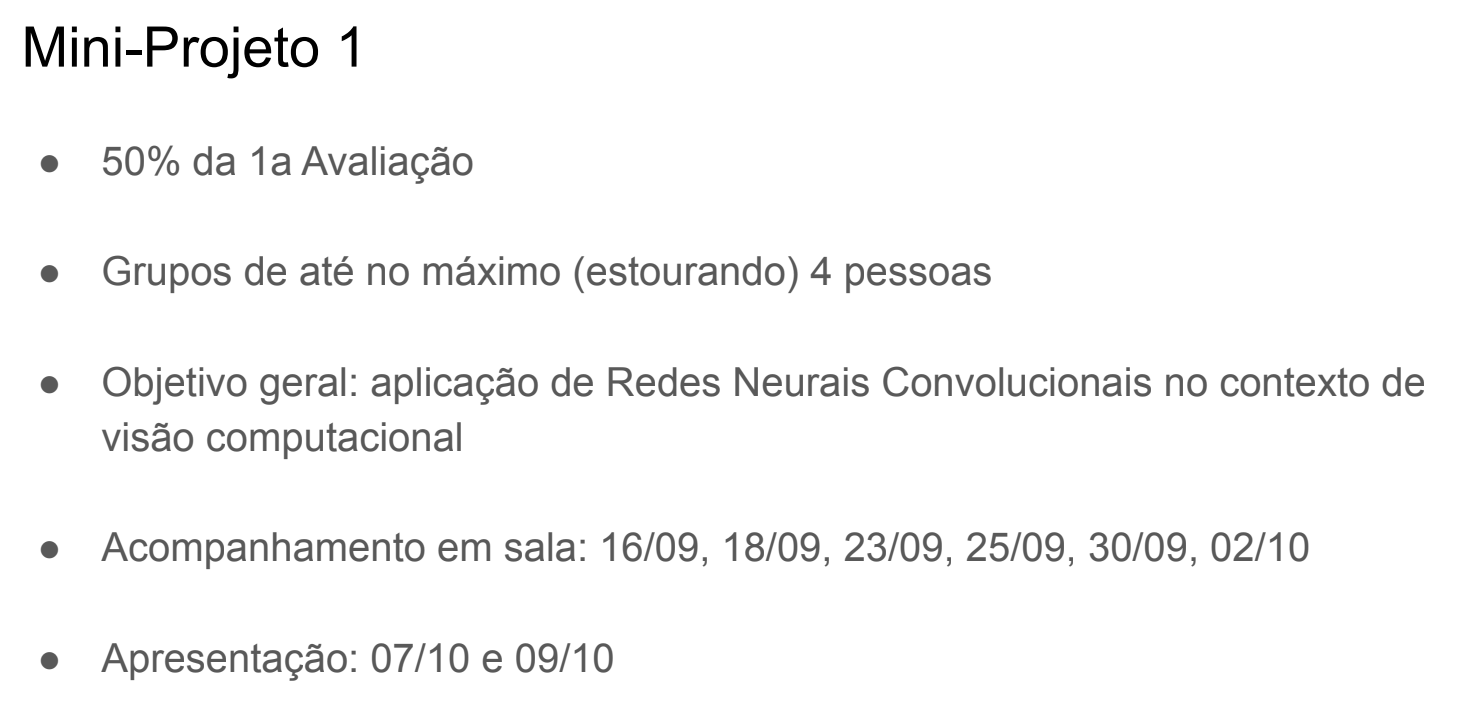

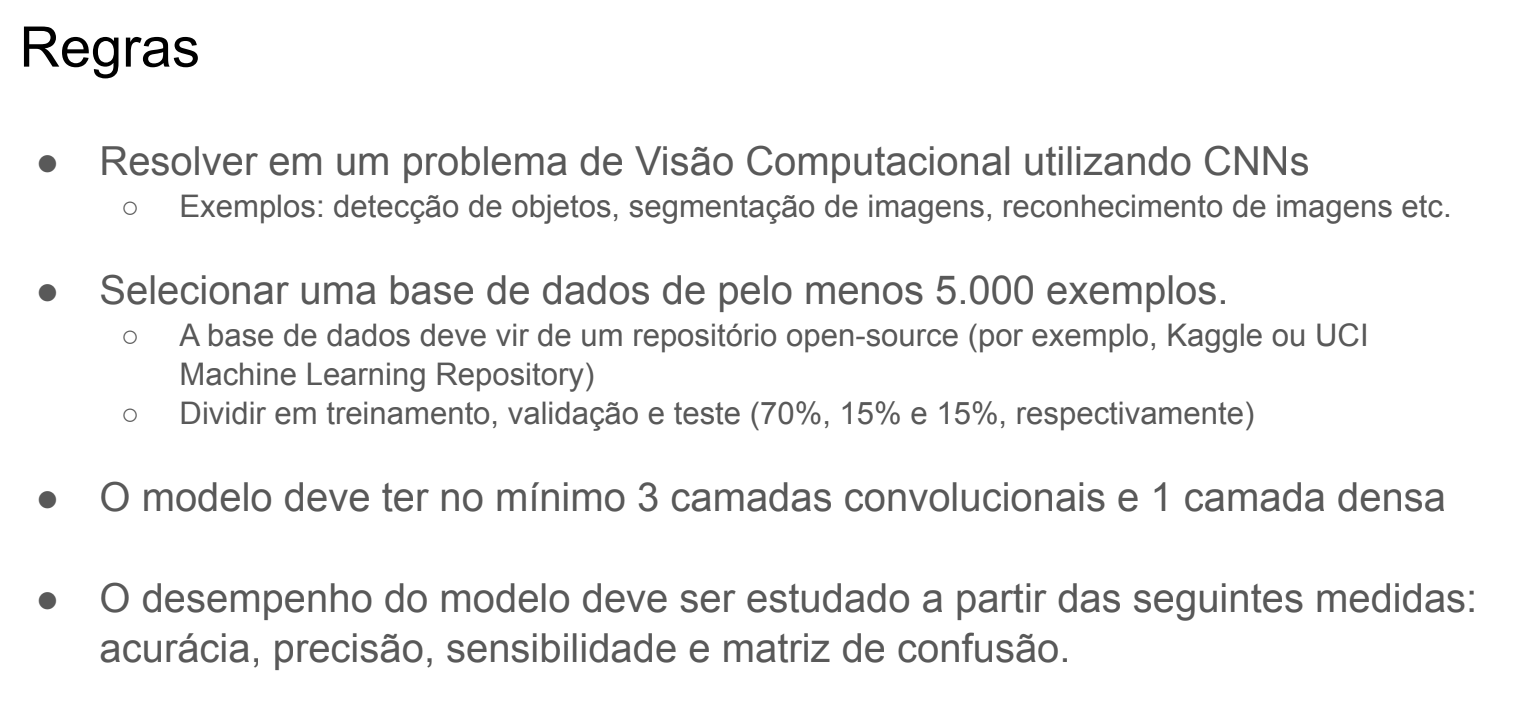

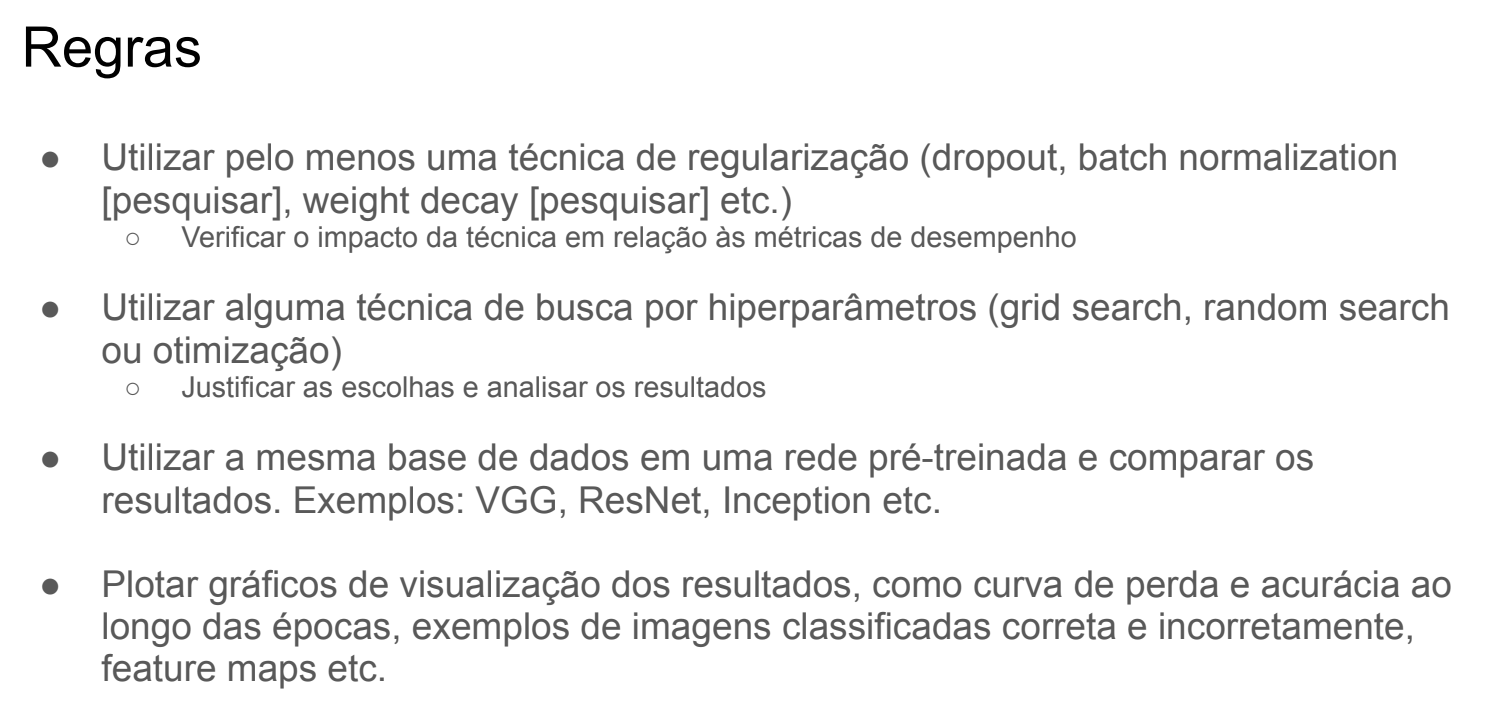

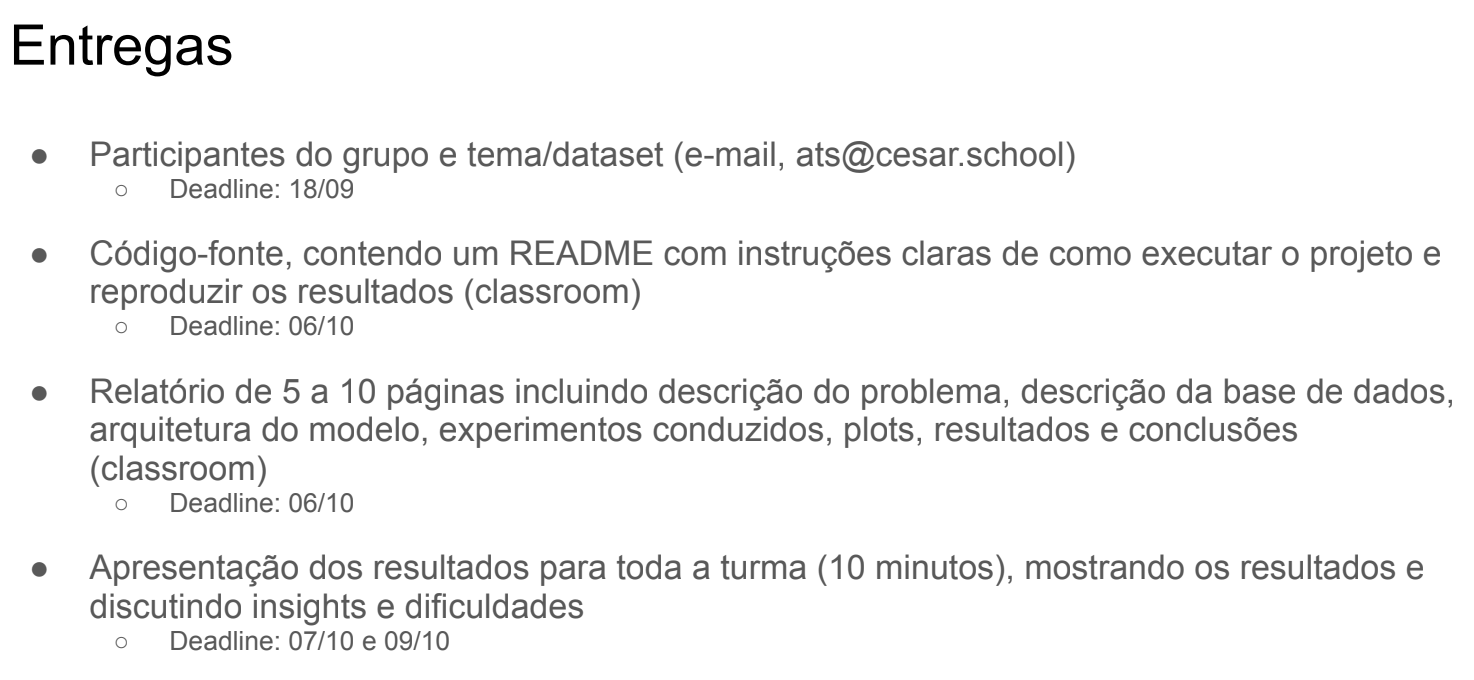

## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

%pip install scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
SEED_VALUE = 42
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

### Dados

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

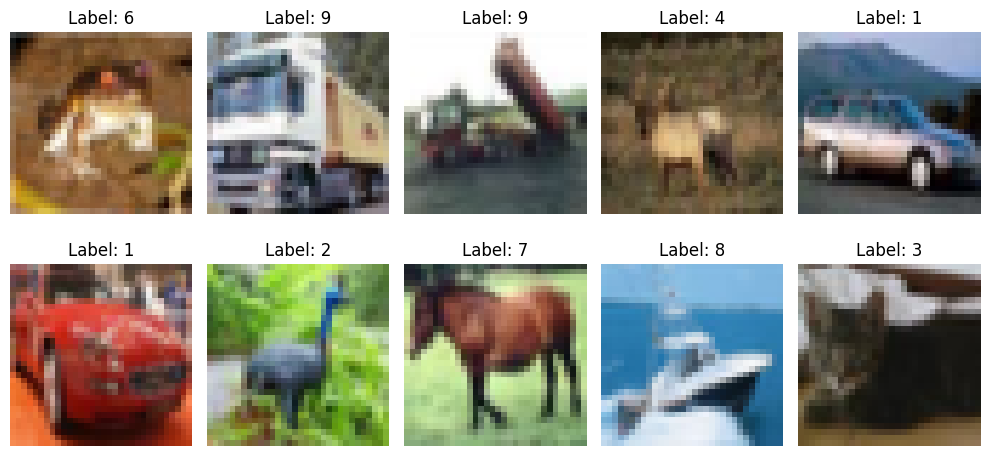

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f'Label: {y_train[i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
X_train.shape

(50000, 32, 32, 3)

Split 80/20 entre dados de treinamento/validação

In [5]:
X_valid = X_train[:10000]
X_train = X_train[10000:]

y_valid = y_train[:10000]
y_train = y_train[10000:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


Normalização dos valores dos pixels das imagens, resultando em uma faixa de valores entre 0 e 1.

In [6]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_valid = X_valid.astype("float32") / 255


y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [7]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

## Utils

plot training/validation loss and accuracy

In [8]:
def plot_results(metrics, ylabel, ylim, metric_name, color):
    epochs =[i for i in range(1,(len(metrics[0]) + 1))]
    plt.plot(epochs, metrics[0], color=color[0], label=metric_name[0])
    plt.plot(epochs, metrics[1], color=color[1], label=metric_name[1])

    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    #plt.ylim(ylim)
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True)

eval func:

In [9]:
def evaluate(X_test, y_test, grid_search=None, model=None,):

    if(model==None) :
        model = grid_search.best_estimator_

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Get the best parameters and best score
    if (grid_search!=None):
      best_params = grid_search.best_params_
      best_score = grid_search.best_score_

    # Print the evaluation results
    print(f"{'='*40}\nEvaluation Metrics\n{'='*40}")

    if (grid_search!=None):
      print(f"Best Parameters : {best_params}")
      print(f"Best Grid Search Score: {best_score:.4f}")

    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"{'='*40}\n")

    # Print detailed classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Create a confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize=12)
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.show()

## Modelo

### Testing

In [12]:
X_train.shape[1], X_train.shape[2], X_train.shape[3]

(32, 32, 3)

In [13]:
X_train.shape

(40000, 32, 32, 3)

#### With Dropout

In [23]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))

#Conv Layers
model.add(Conv2D(32, (3, 3), activation='relu' , kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu' , kernel_initializer='he_uniform'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu' , kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

#Flatten
model.add(Flatten())

#Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

#Output layer
model.add(Dense(10, activation='softmax'))

#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,282 (3.18 MB)

 Trainable params: 834,282 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_result = model.fit(X_train, y_train, epochs=21, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.2390 - loss: 2.0837 - val_accuracy: 0.4660 - val_loss: 1.5266
Epoch 2/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.4479 - loss: 1.5338 - val_accuracy: 0.5268 - val_loss: 1.3448
Epoch 3/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5013 - loss: 1.3845 - val_accuracy: 0.5660 - val_loss: 1.2346
Epoch 4/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5419 - loss: 1.2826 - val_accuracy: 0.5988 - val_loss: 1.1506
Epoch 5/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5718 - loss: 1.2018 - val_accuracy: 0.6217 - val_loss: 1.0763
Epoch 6/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5973 - loss: 1.1438 - val_accuracy: 0.6393 - val_loss: 1.0322
Epoch 7/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.6179 - loss: 1.0764 - val_accuracy: 0.6575 - val_loss: 0.9775
Epoch 8/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.6410 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Evaluation Metrics
Accuracy  : 0.7404
Precision : 0.7391
Recall    : 0.7404
F1-Score  : 0.7388


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1000
           1       0.86      0.82      0.84      1000
           2       0.64      0.64      0.64      1000
           3       0.60      0.48      0.53      1000
           4       0.68      0.72      0.70      1000
           5       0.63      0.66      0.64      1000
           6       0.82      0.81      0.82      1000
           7       0.79      0.78      0.78      1000
           8       0.83      0.85      0.84      1000
           9       0.80      0.84      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



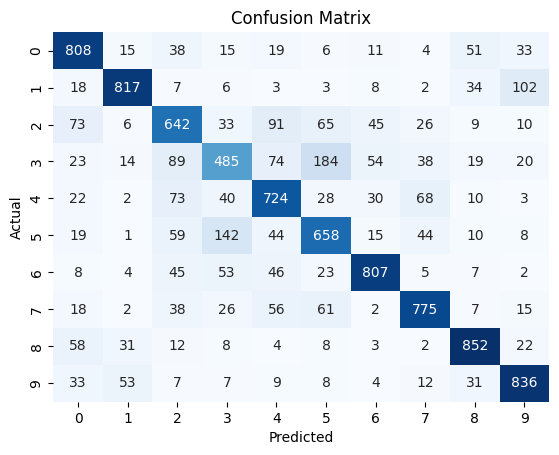

In [25]:
evaluate(X_test, y_test, model=model)

In [26]:
train_loss = model_result.history["loss"]
valid_loss = model_result.history["val_loss"]
train_acc = model_result.history["accuracy"]
valid_acc = model_result.history["val_accuracy"]

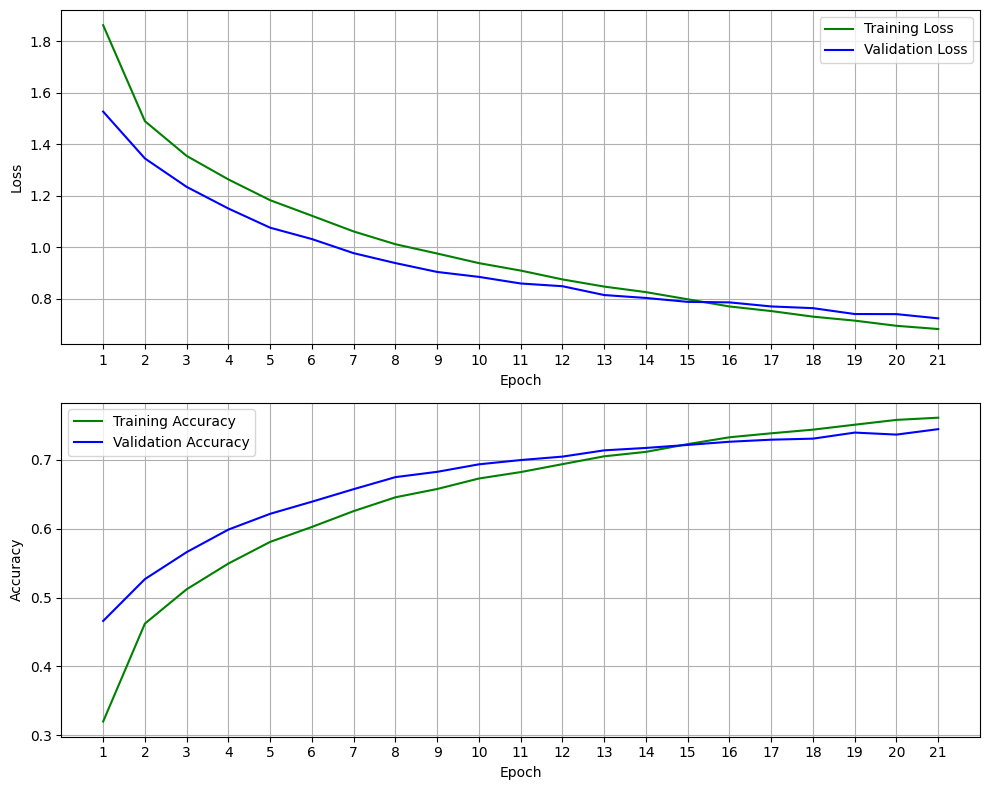

In [27]:
plt.figure(figsize=(10, 8))

#Loss
plt.subplot(2, 1, 1)
plot_results([train_loss, valid_loss],
             ylabel="Loss",
             ylim=[0.0, 0.5],
             metric_name=["Training Loss", "Validation Loss"],
             color=["g", "b"])

# Plot Accuracy
plt.subplot(2, 1, 2)
plot_results([train_acc, valid_acc],
             ylabel="Accuracy",
             ylim=[0.9, 1.0],
             metric_name=["Training Accuracy", "Validation Accuracy"],
             color=["g", "b"])

plt.tight_layout()
plt.show()

#### Without Dropout

In [35]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))

#Conv Layers
model.add(Conv2D(32, (3, 3), activation='relu' , kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu' , kernel_initializer='he_uniform'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu' , kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D())

#Flatten
model.add(Flatten())

#Dense layers
model.add(Dense(256, activation='relu'))

#Output layer
model.add(Dense(10, activation='softmax'))

#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,282 (3.18 MB)

 Trainable params: 834,282 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_result = model.fit(X_train, y_train, epochs=21, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5593 - loss: 1.2599 - val_accuracy: 0.6036 - val_loss: 1.1399
Epoch 2/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6215 - loss: 1.0975 - val_accuracy: 0.6345 - val_loss: 1.0420
Epoch 3/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6579 - loss: 0.9944 - val_accuracy: 0.6528 - val_loss: 0.9838
Epoch 4/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6869 - loss: 0.9151 - val_accuracy: 0.6704 - val_loss: 0.9455
Epoch 5/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.7092 - loss: 0.8476 - val_accuracy: 0.6794 - val_loss: 0.9215
Epoch 6/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.7334 - loss: 0.7841 - val_accuracy: 0.6860 - val_loss: 0.9053
Epoch 7/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.7569 - loss: 0.7241 - val_accuracy: 0.6913 - val_loss: 0.8944
Epoch 8/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.7789 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Evaluation Metrics
Accuracy  : 0.6630
Precision : 0.6804
Recall    : 0.6630
F1-Score  : 0.6554


Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1000
           1       0.85      0.71      0.77      1000
           2       0.60      0.48      0.53      1000
           3       0.61      0.26      0.37      1000
           4       0.70      0.55      0.61      1000
           5       0.46      0.76      0.57      1000
           6       0.66      0.83      0.74      1000
           7       0.74      0.70      0.72      1000
           8       0.84      0.75      0.79      1000
           9       0.62      0.86      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.68      0.66      0.66     10000
weighted avg       0.68      0.66      0.66     10000



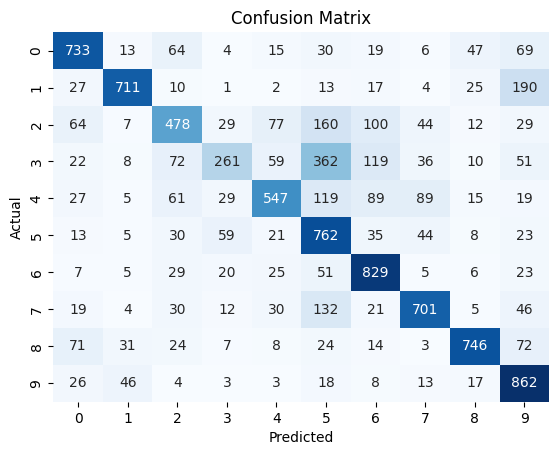

In [38]:
evaluate(X_test, y_test, model=model)

In [39]:
train_loss = model_result.history["loss"]
valid_loss = model_result.history["val_loss"]
train_acc = model_result.history["accuracy"]
valid_acc = model_result.history["val_accuracy"]

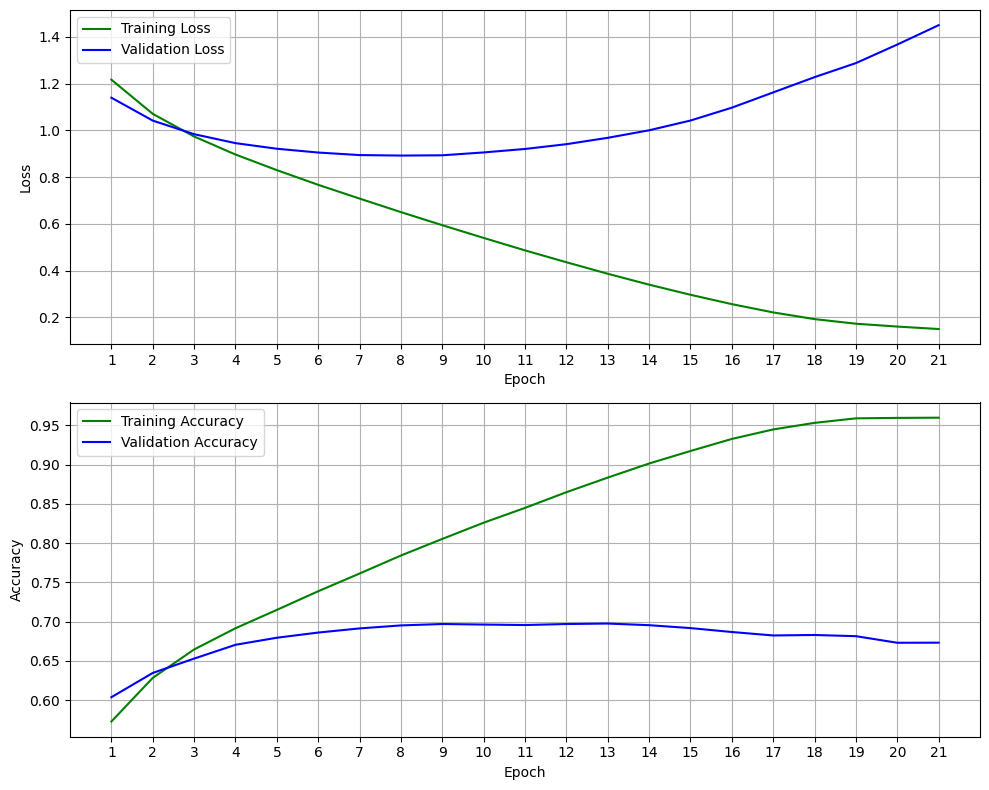

In [40]:
plt.figure(figsize=(10, 8))

#Loss
plt.subplot(2, 1, 1)
plot_results([train_loss, valid_loss],
             ylabel="Loss",
             ylim=[0.0, 0.5],
             metric_name=["Training Loss", "Validation Loss"],
             color=["g", "b"])

# Plot Accuracy
plt.subplot(2, 1, 2)
plot_results([train_acc, valid_acc],
             ylabel="Accuracy",
             ylim=[0.9, 1.0],
             metric_name=["Training Accuracy", "Validation Accuracy"],
             color=["g", "b"])

plt.tight_layout()
plt.show()

### Hyperparameters search

In [10]:
#buil model func
def build_model(activation='relu', neurons=128, num_dense_layers=1, num_conv_layers=3, kernel='he_uniform', model_summary = False,dropout_rate=None):
  model = Sequential()
  model.add(Input(shape=(32,32,3)))

  #Convolucional Layers
  for _ in range(num_conv_layers):
    model.add(Conv2D(32, (3, 3), activation=activation , kernel_initializer=kernel, padding='same'))
    model.add(MaxPooling2D())                                                   # had to add padding because the images are too small for larger number of conv layers

  #Flatten
  model.add(Flatten())

  #Dense layers
  for _ in range(num_dense_layers):
    model.add(Dense(neurons, activation=activation))

  # Output layer
  model.add(Dense(10, activation="softmax"))

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  if model_summary:
    model.summary()
  return model

#### Test Func

In [11]:
model = build_model(model_summary=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,346 (337.29 KB)

 Trainable params: 86,346 (337.29 KB)

 Non-trainable params: 0 (0.00 B)

#### Actual Search

In [12]:
model = KerasClassifier(model=build_model, epochs=5, batch_size=32, random_state=SEED_VALUE)

# hyperparameters to search
param_grid = {
    'model__activation': ['relu', 'sigmoid'],
    'model__num_conv_layers': [3, 5],
    'model__neurons': [128, 256],
    'model__num_dense_layers': [1, 3]
}

#GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Run the grid search
grid_result = grid.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.2394 - loss: 2.0999 - val_accuracy: 0.3933 - val_loss: 1.6495
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 73s 80ms/step - accuracy: 0.2380 - loss: 2.1053 - val_accuracy: 0.4022 - val_loss: 1.6319
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.2444 - loss: 2.0922 - val_accuracy: 0.4045 - val_loss: 1.6437
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 86s 81ms/step - accuracy: 0.2304 - loss: 2.0714 - val_accuracy: 0.4128 - val_loss: 1.6106
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 86s 82ms/step - accuracy: 0.2278 - loss: 2.0821 - val_accuracy: 0.3987 - val_loss: 1.6135
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.2306 - loss: 2.0781 - val_accuracy: 0.4219 - val_loss: 1.5601
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.1943 - loss: 2.1542 - val_ac

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Evaluation Metrics
Best Parameters : {'model__activation': 'relu', 'model__neurons': 256, 'model__num_conv_layers': 3, 'model__num_dense_layers': 3}
Best Grid Search Score: 0.5689
Accuracy  : 0.6180
Precision : 0.6158
Recall    : 0.6180
F1-Score  : 0.6097


Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1000
           1       0.65      0.81      0.72      1000
           2       0.45      0.52      0.49      1000
           3       0.54      0.29      0.38      1000
           4       0.55      0.52      0.54      1000
           5       0.57      0.52      0.54      1000
           6       0.64      0.79      0.71      1000
           7       0.73      0.62      0.67      1000
           8       0.67      0.82      0.74      1000
           9       0.69      0.62      0.65      1000

    accuracy                           0.62     10000
   macro avg       0.62    

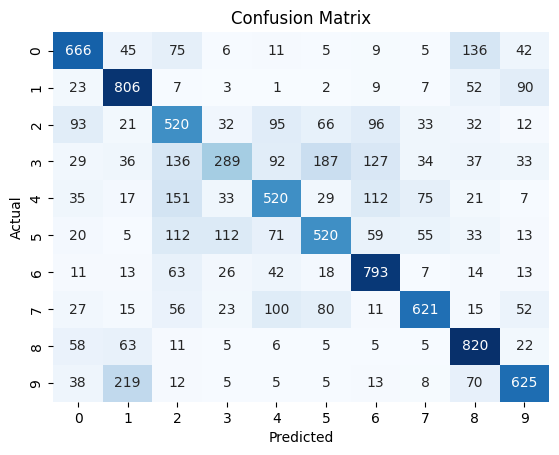

In [13]:
evaluate(X_test, y_test, grid_search = grid_result)